# Capacitated Vehicle Routing Problem

<img src="http://neo.lcc.uma.es/dynamic/images/vrp.png" width="400" />

- $n$ is the number of clientes
- $N$ is set of clients, with $N=\{1,2,...,n\}$
- $V$ is set of vetices (or nodes), with $V=\{0\}\cup N$
- $A$ is set of arcs, with $A=\{(i,j)\in V^2 : i\neq j\}$
- $c_{ij}$ is cost of travel over arc $(i,j)\in A$
- $Q$ is the vehicle capacity
- $q_i$ is the amount that has to be delivered to customer $i\in N$
- $T$ Number of Trucks

Then, the formulation is the following
$$\begin{align}
\min \quad & \sum_{i,j\in A} c_{ij} x_{ij} \\
\text{s.t.} \quad & \sum_{j\in V , j\neq i} x_{ij} = 1  && i \in N \\
& \sum_{i\in V , i\neq j} x_{ij} = 1 && j \in N \\
& \text{if} \ x_{ij}=1 \ \Rightarrow \ u_i + q_j = u_j && i,j \in A : j\neq 0, i\neq 0 \\
& q_i \leq u_i \leq Q && i \in N \\
& x_{ij} \in \{0,1\} && i,j \in A
\end{align}$$

(3.5489376012892917, 175.00941056967486, 9.95105614856251, 99.79953778800665)

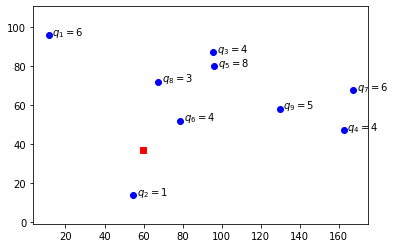

In [226]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
import random 
rnd = np.random
rnd.seed(0)
n = 9
Q = 20
N = [i for i in range(1, n+1)]
V = [0] + N
q = {i: rnd.randint(1, 10) for i in N}
loc_x = rnd.rand(len(V))*200
loc_y = rnd.rand(len(V))*100
T = ceil(sum(q.values())/Q)
A = [(i, j) for i in V for j in V if i != j]
c = {(i, j): np.hypot(loc_x[i]-loc_x[j], loc_y[i]-loc_y[j]) for i, j in A}

pop_size = 50
# c = np.zeros((len(V), len(V)))
# for i in V:
#     for j in V:
#         c[i, j] = np.hypot(loc_x[i]-loc_x[j], loc_y[i]-loc_y[j])

plt.scatter(loc_x[1:], loc_y[1:], c='b')
for i in N:
    plt.annotate('$q_%d=%d$' % (i, q[i]), (loc_x[i]+2, loc_y[i]))
plt.plot(loc_x[0], loc_y[0], c='r', marker='s')
plt.axis('equal')

  Vehicle 1's route: 0 - 6 - 5 - 3 - 8 - 0
  Vehicle 2's route: 0 - 9 - 7 - 4 - 2 - 0
  Vehicle 3's route: 0 - 1 - 0
  Distance :  553.8732191962254


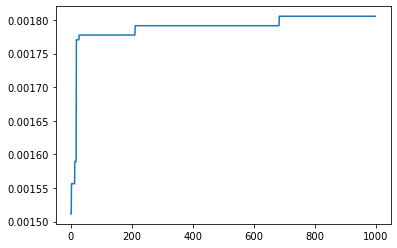

In [272]:
def getRouteCost(route):
    total_cost = 0
    for subroute in route:
        last_stop = 0
        for costumer in subroute:
            total_cost += c[last_stop, costumer]
            last_stop = costumer
        total_cost += c[last_stop, 0]
    return total_cost

def routeToSubroute(raw_route):
    route = []
    sub_route = []
    vehicle_load = 0
    last_stop = 0
    for customer in raw_route:
        updated_vehicle_load = vehicle_load + q[customer]
        if(updated_vehicle_load <= Q):
            sub_route.append(customer)
            vehicle_load = updated_vehicle_load
        else:
            route.append(sub_route)
            sub_route = [customer]
            vehicle_load = q[customer]
    if sub_route != []:
        route.append(sub_route)
    return route

def printRoute(route, merge=False):
    route_str = '0'
    sub_route_count = 0
    for sub_route in route:
        sub_route_count += 1
        sub_route_str = '0'
        for customer_id in sub_route:
            sub_route_str = f'{sub_route_str} - {customer_id}'
            route_str = f'{route_str} - {customer_id}'
        sub_route_str = f'{sub_route_str} - 0'
        if not merge:
            print(f'  Vehicle {sub_route_count}\'s route: {sub_route_str}')
        route_str = f'{route_str} - 0'
    if merge:
        print(route_str)


def fitness(raw_route):
    route = routeToSubroute(raw_route)
    if len(route) <= T:
        total_distance = getRouteCost(route)
        if total_distance > 0:
            return 1 / total_distance
        else:
            return 2
    else:
        return 0
    

def init_population(size, genes_number=9):
    import itertools
    permutations = itertools.permutations(list(range(1, genes_number + 1)), r=None)
    population = random.sample(list(permutations), size)
    return [list(p) for p in population]

def cross_over_prob(epoch, total_epochs):
    if epoch < total_epochs * 0.1:
        return 90
    else:
        k = 50
        return k

def cross_over(p1, p2, prob):
    if random.randint(0,100) < prob:
        point1 = random.randint(1, len(p1) - 3)
        point2 = random.randint(point1, len(p1) - 2) + 1
        child1 = p2[point1 : point2]
        child2 = p1[point1 : point2]
        i = point2
        while(len(child1) < len(p1)):
            if i == len(p1):
                i = 0
            if p1[i] not in child1:
                child1.append(p1[i])
            i+=1
        i = point2
        while(len(child2) < len(p2)):
            if i == len(p2):
                i = 0
            if p2[i] not in child2:
                child2.append(p2[i])
            i+=1
        return child1, child2
    else:
        return p1, p2

def chose_two(routes):
    routes.sort(key=fitness, reverse=True)
    return routes[0], routes[1]

def mutation_prob(epoch, total_epochs):
    if epoch < total_epochs * 0.1:
        return 5 # 0.005
    else:
        k = 5
        return k

def mutation(p1, p2, prob):
    if random.randint(0,100) < prob:
        point1 = random.randint(1, len(p1) - 3)
        point2 = random.randint(point1, len(p1) - 2) + 1
        mid1 = p1[point1 : point2]
        mid1.reverse()
        child1 = p1[0 : point1] + mid1 + p1[point2 : ]
        if random.randint(0,100) < prob:
            point1 = random.randint(1, len(p1) - 3)
            point2 = random.randint(point1, len(p1) - 2) + 1
            mid2 = p2[point1 : point2]
            mid2.reverse()
            child2 = p2[0 : point1] + mid2 + p2[point2 : ]
            return child1, child2
        else:
            return child1, p2
    else:
        if random.randint(0,100) < prob:
            point1 = random.randint(1, len(p1) - 3)
            point2 = random.randint(point1, len(p1) - 2) + 1
            mid2 = p2[point1 : point2]
            mid2.reverse()
            child2 = p2[0 : point1] + mid2 + p2[point2 : ]
            return p1, child2
        else:
            return p1, p2


def tournament_selection(population):
    k = 5
    selected = random.sample(list(enumerate(population)), k)
    selected.sort(reverse=True, key= lambda a: fitness(a[1]))
    return selected[0], selected[1]

def survival_selection(idx1, child1, idx2, child2, population):
    population[idx1] = child1
    population[idx2] = child2
    return population

def fit(population, epochs):
    best_solution = []
    for i in range(epochs):
        # LOG
        fitness_list = list(map(fitness, population))
        best_fit.append(max(fitness_list))
        if max(best_fit) == best_fit[-1]:
            best_solution = population[fitness_list.index(best_fit[-1])]
        average_fit.append(sum(fitness_list)/ len(fitness_list))
        # Main
        p1, p2 = tournament_selection(population)
        prob = cross_over_prob(i, epochs)
        child1, child2 = cross_over(p1[1], p2[1], prob)
        child1, child2 = chose_two([child1, child2, p1[1], p2[1]])
        prob = mutation_prob(i, epochs)
        child1, child2 = mutation(child1, child2, prob)
        survival_selection(p1[0], child1, p2[0], child2, population)
    return best_solution

best_fit = []
average_fit = []
best_solution = 0
epochs = 1000
population = init_population(pop_size)
best_solution = fit(population, epochs)
printRoute(routeToSubroute(best_solution))
f = fitness(best_solution)
print('  Distance : ', 1/f)
plt.plot(list(range(len(best_fit))), best_fit)